In [1]:
from pathlib import Path
from xml.dom import minidom
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import SimpleITK as sitk

from tqdm import tqdm

import os
import shutil
import filecmp

from bs4 import BeautifulSoup

from landmarks_info import *

In [29]:
def get_landmark_coords_from_table(df, sample, pointset, landmark, name):
    df_query = res_df[(df['sample'] == sample)]
    df_query = df_query[df_query['point_set'] == pointset]
    df_query = df_query[df_query['landmark'] == landmark]
    df_query = df_query[df_query['name'] == name]

    x = df_query.iloc[0].x
    y = df_query.iloc[0].y
    z = df_query.iloc[0].z

    return x,y,z

def make_landmarks_comparison_figure(im, land1, land2, landmark_name, name1, name2, color1 = 'red', color2 = 'blue'):

    marker_size = 5
    marker_alpha = 0.7
    line_width = 0.5

    x = math.floor(land1[0])
    y = math.floor(land1[1])
    z = math.floor(land1[2])

    x2 = math.floor(land2[0])
    y2 = math.floor(land2[1])
    z2 = math.floor(land2[2])
    
    diff = round(get_distance(land1, land2),1)

    fig = plt.figure(figsize= (13,11), layout="tight")

    gs = GridSpec(4, 2, figure=fig)
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[1, 0])
    ax3 = fig.add_subplot(gs[2,0])
    ax4 = fig.add_subplot(gs[3, 0])
    ax5 = fig.add_subplot(gs[0:2, 1])
    ax6 = fig.add_subplot(gs[2:4, 1])

    for i, ax in enumerate(fig.axes):
        ax.set_xticks([])
        ax.set_yticks([])  

    fig.suptitle(f"{landmark_name}    [{name1} and {name2}]    Diff = {diff} px", color='white')

    fig.patch.set_facecolor('black')

    #-------------------------
    # Front 1
    #-------------------------

    ax5.imshow(im[z], cmap='gray')
    # Markers
    ax5.plot(x,y,'ro', markersize=marker_size, alpha=marker_alpha)
    ax5.plot(x2,y2,'bo', markersize=marker_size, alpha=marker_alpha)

    # Lines
    ax5.plot([0, im.shape[2]-1], [y, y], 'r', linestyle = 'dashed', linewidth=line_width)
    ax5.plot([x, x], [0, im.shape[1]-1], 'r', linestyle = 'dashed', linewidth=line_width)

    ax5.text(0.05, 0.95, name1, horizontalalignment='center',
         verticalalignment='center', transform=ax5.transAxes, bbox=dict(facecolor='black', alpha=0.5), color=color1, fontsize=12)

    #-------------------------
    # Front 2
    #-------------------------

    ax6.imshow(im[z2], cmap='gray')
    # Markers
    ax6.plot(x,y,'ro', markersize=marker_size, alpha=marker_alpha)
    ax6.plot(x2,y2,'bo', markersize=marker_size, alpha=marker_alpha)

    # Lines
    ax6.plot([0, im.shape[2]-1], [y2, y2], 'b', linestyle = 'dashed', linewidth=line_width)
    ax6.plot([x2, x2], [0, im.shape[1]-1], 'b', linestyle = 'dashed', linewidth=line_width)

    ax6.text(0.05, 0.95, name2, horizontalalignment='center',
         verticalalignment='center', transform=ax6.transAxes, bbox=dict(facecolor='black', alpha=0.5), color=color2, fontsize=12)
    #-------------------------
    # Top 1
    #-------------------------
    ax1.imshow(im[:, y, :].T, cmap='gray')
    ax1.plot(z,x,'ro', markersize=marker_size, alpha=marker_alpha)
    ax1.plot(z2,x2,'bo', markersize=marker_size, alpha=marker_alpha)

    # Lines
    ax1.plot([0, im.shape[0]-1], [x, x], 'r', linestyle = 'dashed', linewidth=line_width)
    ax1.plot([z, z], [0, im.shape[2]-1], 'r', linestyle = 'dashed', linewidth=line_width)

    ax1.text(0.05, 0.95, name1, horizontalalignment='center',
         verticalalignment='center', transform=ax1.transAxes, bbox=dict(facecolor='black', alpha=0.5), color=color1, fontsize=12)
    #-------------------------
    # Top 2
    #-------------------------
    ax2.imshow(im[:, y2, :].T, cmap='gray')
    ax2.plot(z,x,'ro', markersize=marker_size, alpha=marker_alpha)
    ax2.plot(z2,x2,'bo', markersize=marker_size, alpha=marker_alpha)

    # Lines
    ax2.plot([0, im.shape[0]-1], [x2, x2], 'b', linestyle = 'dashed', linewidth=line_width)
    ax2.plot([z2, z2], [0, im.shape[2]-1], 'b', linestyle = 'dashed', linewidth=line_width)

    ax2.text(0.05, 0.95, name2, horizontalalignment='center',
         verticalalignment='center', transform=ax2.transAxes, bbox=dict(facecolor='black', alpha=0.5), color=color2, fontsize=12)
    #-------------------------
    # Side 1
    #-------------------------
    ax3.imshow(im[:, :, x].T, cmap='gray')
    ax3.plot(z,y,'ro', markersize=marker_size, alpha=marker_alpha)
    ax3.plot(z2,y2,'bo', markersize=marker_size, alpha=marker_alpha)

    # Lines
    ax3.plot([0, im.shape[0]-1], [y, y], 'r', linestyle = 'dashed', linewidth=line_width)
    ax3.plot([z, z], [0, im.shape[1]-1], 'r', linestyle = 'dashed', linewidth=line_width)

    ax3.text(0.05, 0.95, name1, horizontalalignment='center',
         verticalalignment='center', transform=ax3.transAxes, bbox=dict(facecolor='black', alpha=0.5), color=color1, fontsize=12)

    #-------------------------
    # Side 2
    #-------------------------
    ax4.imshow(im[:, :, x2].T, cmap='gray')
    ax4.plot(z,y,'ro', markersize=marker_size, alpha=marker_alpha)
    ax4.plot(z2,y2,'bo', markersize=marker_size, alpha=marker_alpha)

    # Lines
    ax4.plot([0, im.shape[0]-1], [y2, y2], 'b', linestyle = 'dashed', linewidth=line_width)
    ax4.plot([z2, z2], [0, im.shape[1]-1], 'b', linestyle = 'dashed', linewidth=line_width)

    ax4.text(0.05, 0.95, name2, horizontalalignment='center',
         verticalalignment='center', transform=ax4.transAxes, bbox=dict(facecolor='black', alpha=0.5), color=color2, fontsize=12)


    plt.show()

    #plt.savefig(res_path / f'res_{dataset}.png')

In [11]:
path = Path("c:\\Users\\fe0968\\Documents\\Medaka\\")
path_eval = Path("c:\\Users\\fe0968\\Documents\\Medaka\\evaluation\\")
path_output = Path("c:\\Users\\fe0968\\Documents\\Medaka\\landmarks_evaluation_vis\\")
path_landmarks = Path('c:\\Users\\fe0968\\Documents\\Medaka\\inbredpanel_pointsets_v6\\inbredpanel_pointsets\\')

#path_eval = Path("/mnt/LSDF/tomo/ershov/medaka/workshop_landmarks/evaluation/")
#path_output = Path("/mnt/LSDF/tomo/ershov/medaka/workshop_landmarks/evaluation_vis")



In [164]:
def get_landmark_index(all_land, pointset_name, landmark_name):
    for p in all_land:
        if p['file_name'] == pointset_name:
            return p['landmarks'].index(landmark_name)
    return -1
        

all_landmarks = [set_vert, set_fins, set_digest, set_heart, set_eyes, set_skull_front, set_skull_center, set_skull_end, set_brain]

landmarks_pointset_names = [x['file_name'] for x in all_landmarks]

print(landmarks_pointset_names)

['pointset1_vert', 'pointset2_fins', 'pointset3_digest', 'pointset4_heart', 'pointset5_eyes', 'pointset6_skull_front', 'pointset7_skull_center', 'pointset8_skull_end', 'pointset9_brain']


In [166]:
get_landmark_index(all_landmarks, 'pointset2_fins', 'Pectoral_dorsal most breast fin to body connection 1_right')

0

In [5]:
eval_df = pd.read_excel(path_eval / 'comp_pointset_fins.xlsx')
res_df = pd.read_excel(path / 'results_landmarks.xlsx')


In [72]:
eval_df

,Unnamed: 0,sample,point_set,landmark,name1,name2,result
0,491,1157,pointset2_fins,Abdominal_fins back 2_left,jo,jvm,1508.650355
1,159,1291,pointset2_fins,Abdominal_fins back 2_left,jo,jvm,1136.896604
2,525,1226,pointset2_fins,Pectoral_dorsal most breast fin to body connec...,cs,tc,915.807890
3,444,1076,pointset2_fins,Pectoral_dorsal most breast fin to body connec...,jo,jvm,83.481820
4,190,909,pointset2_fins,Abdominal_fins back 1_right,cs,tc,70.472645
...,...,...,...,...,...,...,...
543,312,1100,pointset2_fins,Pectoral_dorsal most breast fin to body connec...,cs,tc,1.800812
544,185,891,pointset2_fins,Pectoral_dorsal most breast fin to body connec...,cs,tc,1.507337
545,232,883,pointset2_fins,Pectoral_dorsal most breast fin to body connec...,cs,tc,1.457993
546,314,1100,pointset2_fins,Abdominal_fins back 1_right,cs,tc,0.000000


In [73]:
ld = list(eval_df["landmark"].unique())

eval_df[eval_df['landmark'] == ld[1]]

,Unnamed: 0,sample,point_set,landmark,name1,name2,result
2,525,1226,pointset2_fins,Pectoral_dorsal most breast fin to body connec...,cs,tc,915.807890
5,333,1191,pointset2_fins,Pectoral_dorsal most breast fin to body connec...,jo,jvm,66.176956
6,301,824,pointset2_fins,Pectoral_dorsal most breast fin to body connec...,jo,jvm,65.566106
7,445,1076,pointset2_fins,Pectoral_dorsal most breast fin to body connec...,jo,jvm,64.172293
9,449,1234,pointset2_fins,Pectoral_dorsal most breast fin to body connec...,jo,jvm,60.394304
...,...,...,...,...,...,...,...
536,317,954,pointset2_fins,Pectoral_dorsal most breast fin to body connec...,cs,tc,2.787723
538,341,1405,pointset2_fins,Pectoral_dorsal most breast fin to body connec...,kp,ttt,2.633439
539,101,946,pointset2_fins,Pectoral_dorsal most breast fin to body connec...,cs,tc,2.368940
541,541,859,pointset2_fins,Pectoral_dorsal most breast fin to body connec...,cs,tc,2.287255


In [22]:
res_df

,Unnamed: 0,sample,point_set,landmark,name,x,y,z
0,0,1248,pointset1_vert,Transition skull to spine,cs,314.406183,300.980854,779.166180
1,1,1248,pointset1_vert,Vert1,cs,313.882716,265.078955,834.213867
2,2,1248,pointset1_vert,Vert2,cs,313.000000,254.473229,871.113307
3,3,1248,pointset1_vert,Vert3,cs,310.116663,248.225450,911.876401
4,4,1248,pointset1_vert,Vert4,cs,308.233326,241.025843,954.962779
...,...,...,...,...,...,...,...,...
19663,19663,1226,pointset9_brain,OT_rightmost,rs,210.000000,252.988723,526.737990
19664,19664,1226,pointset9_brain,OT_leftmost,rs,402.266461,246.457130,525.101989
19665,19665,1226,pointset9_brain,cerebellum,rs,302.240511,209.375536,601.098695
19666,19666,1226,pointset9_brain,OT cerebellum torus,rs,304.032449,203.514767,543.000000


In [55]:
top_df = eval_df.sort_values(by='result', ascending=False).head(3)
top_df

,Unnamed: 0,sample,point_set,landmark,name1,name2,result
748,748,1075,pointset1_vert,Vert_Last_Center,jo,jvm,2602.492980
363,363,1106,pointset1_vert,Vert_Last_Center,jo,jvm,2556.419809
979,979,1064,pointset1_vert,Vert_Last_Center,jo,jvm,2541.045867


In [62]:
#for p in landmarks_pointset_names:
for ps in ['pointset1_vert']:
    
    path_out = path_output / ps
    path_out.mkdir(parents=True, exist_ok=True)
    
    eval_df = pd.read_excel(path_eval / f'comp_{ps}.xlsx')
    
    # Top differences between 2 people
    TOP_COUNT = 3
    top_df = eval_df.sort_values(by='result', ascending=False).head(TOP_COUNT)
    
    print(top_df.index.tolist())
    
    print('Hi', top_df.loc[top_df.index.tolist()[0]]['sample'])

    # for the selected results
    for i in top_df.index:
        sample = top_df.loc[i]['sample']
        pointset = top_df.loc[i]['point_set']
        name1 = top_df.loc[i]['name1']
        name2 = top_df.loc[i]['name2']
        landmark = top_df.loc[i]['landmark']
        
        print(i)

        # Depricated
        #fname1 = f"{sample}_{pointset}_{name1}.mps"
        #fname2 = f"{sample}_{pointset}_{name2}.mps"
        #print(f"{df_pointset.loc[i]['sample']}_{df_pointset.loc[i]['point_set']}_{df_pointset.loc[i]['name']}.mps")
        #land1 = read_landmarks(path_landmarks / fname1)
        #land2 = read_landmarks(path_landmarks / fname2)

        x,y,z = get_landmark_coords_from_table(res_df, sample, pointset, landmark, name1)
        print([x,y,z])

        x2,y2,z2 = get_landmark_coords_from_table(res_df, sample, pointset, landmark, name2)
        print([x2,y2,z2])

        # Read sample
        #dataset = '1064'
        #sitk_image = sitk.ReadImage(volumes_path / f'{dataset}.tif')
        #im = sitk.GetArrayViewFromImage(sitk_image)

        #make_landmarks_comparison_figure(im, [x,y,z], [x2,y2,z2], f'{pointset}: {landmark}', name1, name2)

    
    #print(sample)

[748, 363, 979]
Hi 1075
748
[0.0, 0.0, 0.0]
[344.830584653, 575.106356812, 2514.62010153]
363
[0.0, 0.0, 0.0]
[568.030001643, 613.721425899, 2415.77527228]
979
[0.0, 0.0, 0.0]
[310.69604472, 671.283148974, 2431.0]


In [176]:
ps = 'pointset4_heart'
  
eval_df = pd.read_excel(path_eval / f'eval_{ps}.xlsx')
    
# Top differences between 2 people
TOP_COUNT = 20
top_df = eval_df.sort_values(by='result', ascending=False).head(TOP_COUNT)

top_df
#print(top_df.index.tolist())
#print('Hi', top_df.loc[top_df.index.tolist()[0]]['sample'])


,Unnamed: 0,sample,point_set,landmark,name1,name2,result
6,6,1300,pointset4_heart,apex of ventricle,vc,bew,85.986893
394,394,1064,pointset4_heart,apex of ventricle,kk,tt,80.477901
406,406,1295,pointset4_heart,apex of ventricle,kk,tt,67.990573
122,122,804,pointset4_heart,apex of ventricle,kk,tt,61.915473
102,102,843,pointset4_heart,apex of ventricle,kk,tt,57.025715
282,282,805,pointset4_heart,apex of ventricle,kk,tt,48.393443
302,302,1227,pointset4_heart,apex of ventricle,bew,vc,47.946677
198,198,800,pointset4_heart,apex of ventricle,kk,tt,47.546857
26,26,814,pointset4_heart,apex of ventricle,kk,tt,46.267014
390,390,816,pointset4_heart,apex of ventricle,kk,tt,43.412906


In [154]:
i = 506
top_df.loc[i]

Unnamed: 0                506
sample                    946
point_set     pointset9_brain
landmark          OT_leftmost
name1                      cs
name2                      rs
result              16.806889
Name: 506, dtype: object

In [155]:

sample = top_df.loc[i]['sample']
pointset = top_df.loc[i]['point_set']
name1 = top_df.loc[i]['name1']
name2 = top_df.loc[i]['name2']
landmark = top_df.loc[i]['landmark']

In [156]:
volumes_path = Path('z:\\tomo\\ershov\\medaka\\workshop_landmarks\\data\\')

sitk_image = sitk.ReadImage(volumes_path / f'{sample}.tif')
im = sitk.GetArrayViewFromImage(sitk_image)

In [157]:
fname1 = f"{sample}_{pointset}_{name1}.mps"
fname2 = f"{sample}_{pointset}_{name2}.mps"
#print(f"{df_pointset.loc[i]['sample']}_{df_pointset.loc[i]['point_set']}_{df_pointset.loc[i]['name']}.mps")

x,y,z = get_landmark_coords_from_table(res_df, sample, pointset, landmark, name1)
print([x,y,z], name1)

x2,y2,z2 = get_landmark_coords_from_table(res_df, sample, pointset, landmark, name2)
print([x2,y2,z2], name2)
        

[416.180827638, 272.091196966, 423.715118511] cs
[416.214532027, 286.605794671, 415.241817623] rs


In [174]:
def center_crop_with_padding(im, x, y, crop_w=400, crop_h=200):
   
    res = np.zeros((crop_h, crop_w))

    x1 = 0 if x < int(crop_w / 2) else x-int(crop_w / 2)
    y1 = 0 if y < int(crop_h / 2) else y-int(crop_h / 2)

    offset_x = 0 if x > int(crop_w / 2) else int(crop_w / 2) -x
    offset_y = 0 if y > int(crop_h / 2) else int(crop_h / 2) -y

    x2 = im.shape[1] if x > im.shape[1] - int(crop_w / 2) else x+int(crop_w / 2)
    y2 = im.shape[0] if y > im.shape[0] - int(crop_h / 2) else y+int(crop_h / 2)

    im_cr = im[y1:y2,x1:x2]

    res[offset_y:offset_y+im_cr.shape[0],offset_x:offset_x+im_cr.shape[1]] = im_cr
   
    return res

def make_landmarks_comparison_figure_centered(im, land1, land2, landmark_name, name1, name2, color1 = 'red', color2 = 'blue'):

    marker_size = 5
    marker_alpha = 0.7
    line_width = 0.5

    x = math.floor(land1[0])
    y = math.floor(land1[1])
    z = math.floor(land1[2])

    x2 = math.floor(land2[0])
    y2 = math.floor(land2[1])
    z2 = math.floor(land2[2])
    
    zero_land1 = ' (ZERO)' if x == 0 and y == 0 and z == 0 else ''
    zero_land2 = ' (ZERO)' if x2 == 0 and y2 == 0 and z2 == 0 else ''
    
    diff = round(get_distance(land1, land2),1)

    fig = plt.figure(figsize= (14,6), layout="tight")

    gs = GridSpec(2, 3, figure=fig)
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[1, 0])
    ax3 = fig.add_subplot(gs[0, 1])
    ax4 = fig.add_subplot(gs[1, 1])
    ax5 = fig.add_subplot(gs[0, 2])
    ax6 = fig.add_subplot(gs[1, 2])

    for i, ax in enumerate(fig.axes):
        ax.set_xticks([])
        ax.set_yticks([])  

    fig.suptitle(f"{landmark_name}    [{name1} and {name2}]    Diff = {diff} px", color='white')

    fig.patch.set_facecolor('black')

    #-------------------------
    # Front 1
    #-------------------------
    im_cr = center_crop_with_padding(im[z],x,y)
    cx,cy = int(im_cr.shape[1]/2), int(im_cr.shape[0]/2)
    ax5.imshow(im_cr, cmap='gray')
    # Markers
    ax5.plot(cx,cy,'ro', markersize=marker_size, alpha=marker_alpha)
    
    cx2,cy2 = cx +(x2-x),cy + (y2-y)
    if not (cx2 > im_cr.shape[1] or cx2 < 0 or cy2 > im_cr.shape[0] or cy2 < 0):
        #print('Fuck, out')
        ax5.plot(cx2,cy2,'bo', markersize=marker_size, alpha=marker_alpha)

    # Lines
    #ax5.plot([0, im.shape[2]-1], [y, y], 'r', linestyle = 'dashed', linewidth=line_width)
    #ax5.plot([x, x], [0, im.shape[1]-1], 'r', linestyle = 'dashed', linewidth=line_width)

    ax5.text(0.01, 0.95, name1 + zero_land1, horizontalalignment='left',
         verticalalignment='center', transform=ax5.transAxes, bbox=dict(facecolor='black', alpha=0.5), color=color1, fontsize=12)

    #-------------------------
    # Front 2
    #-------------------------
    im_cr = center_crop_with_padding(im[z2],x2,y2)
    cx,cy = int(im_cr.shape[1]/2), int(im_cr.shape[0]/2)
    ax6.imshow(im_cr, cmap='gray')
    # Markers
    ax6.plot(cx,cy,'bo', markersize=marker_size, alpha=marker_alpha)
    
    cx2,cy2 = cx +(x-x2),cy + (y-y2)
    if not (cx2 > im_cr.shape[1] or cx2 < 0 or cy2 > im_cr.shape[0] or cy2 < 0):
        ax6.plot(cx2,cy2 ,'ro', markersize=marker_size, alpha=marker_alpha)

    # Lines
    #ax6.plot([0, im.shape[2]-1], [y2, y2], 'b', linestyle = 'dashed', linewidth=line_width)
    #ax6.plot([x2, x2], [0, im.shape[1]-1], 'b', linestyle = 'dashed', linewidth=line_width)

    ax6.text(0.01, 0.95, name2+zero_land2, horizontalalignment='left',
         verticalalignment='center', transform=ax6.transAxes, bbox=dict(facecolor='black', alpha=0.5), color=color2, fontsize=12)
    #-------------------------
    # Top 1
    #-------------------------
    im_cr = center_crop_with_padding(im[:, y, :].T,z,x)
    cx,cy = int(im_cr.shape[1]/2), int(im_cr.shape[0]/2)
    ax1.imshow(im_cr, cmap='gray')
    ax1.plot(cx,cy,'ro', markersize=marker_size, alpha=marker_alpha)
    #ax1.plot(z2,x2,'bo', markersize=marker_size, alpha=marker_alpha) # Old
    cx2,cy2 = cx +(z2-z),cy + (x2-x)
    if not (cx2 > im_cr.shape[1] or cx2 < 0 or cy2 > im_cr.shape[0] or cy2 < 0):
        ax1.plot(cx2,cy2,'bo', markersize=marker_size, alpha=marker_alpha)
    
    # Lines
    #ax1.plot([0, im.shape[0]-1], [x, x], 'r', linestyle = 'dashed', linewidth=line_width)
    #ax1.plot([z, z], [0, im.shape[2]-1], 'r', linestyle = 'dashed', linewidth=line_width)

    ax1.text(0.01, 0.95, name1+zero_land1, horizontalalignment='left',
         verticalalignment='center', transform=ax1.transAxes, bbox=dict(facecolor='black', alpha=0.5), color=color1, fontsize=12)
    #-------------------------
    # Top 2
    #-------------------------
    im_cr = center_crop_with_padding(im[:, y2, :].T,z2,x2)
    cx,cy = int(im_cr.shape[1]/2), int(im_cr.shape[0]/2)
    ax2.imshow(im_cr, cmap='gray')
    cx2,cy2 = cx +(z-z2),cy + (x-x2)
    if not (cx2 > im_cr.shape[1] or cx2 < 0 or cy2 > im_cr.shape[0] or cy2 < 0):
        ax2.plot(cx2,cy2,'ro', markersize=marker_size, alpha=marker_alpha)
        
    ax2.plot(cx,cy,'bo', markersize=marker_size, alpha=marker_alpha)

    # Lines
    #ax2.plot([0, im.shape[0]-1], [x2, x2], 'b', linestyle = 'dashed', linewidth=line_width)
    #ax2.plot([z2, z2], [0, im.shape[2]-1], 'b', linestyle = 'dashed', linewidth=line_width)

    ax2.text(0.01, 0.95, name2+zero_land2, horizontalalignment='left',
         verticalalignment='center', transform=ax2.transAxes, bbox=dict(facecolor='black', alpha=0.5), color=color2, fontsize=12)
    #-------------------------
    # Side 1
    #-------------------------
    im_cr = center_crop_with_padding(im[:, :, x].T,z,y)
    cx,cy = int(im_cr.shape[1]/2), int(im_cr.shape[0]/2)
    ax3.imshow(im_cr, cmap='gray')
    ax3.plot(cx,cy,'ro', markersize=marker_size, alpha=marker_alpha)
    cx2,cy2 = cx + (z2-z),cy + (y2-y)
    if not (cx2 > im_cr.shape[1] or cx2 < 0 or cy2 > im_cr.shape[0] or cy2 < 0):
        ax3.plot(cx2,cy2,'bo', markersize=marker_size, alpha=marker_alpha)

    # Lines
    #ax3.plot([0, im.shape[0]-1], [y, y], 'r', linestyle = 'dashed', linewidth=line_width)
    #ax3.plot([z, z], [0, im.shape[1]-1], 'r', linestyle = 'dashed', linewidth=line_width)

    ax3.text(0.01, 0.95, name1+zero_land1, horizontalalignment='left',
         verticalalignment='center', transform=ax3.transAxes, bbox=dict(facecolor='black', alpha=0.5), color=color1, fontsize=12)

    #-------------------------
    # Side 2
    #-------------------------
    im_cr = center_crop_with_padding(im[:, :, x2].T,z2,y2)
    cx,cy = int(im_cr.shape[1]/2), int(im_cr.shape[0]/2)
    ax4.imshow(im_cr, cmap='gray')
    cx2,cy2 = cx + (z-z2),cy+(y-y2)
    if not (cx2 > im_cr.shape[1] or cx2 < 0 or cy2 > im_cr.shape[0] or cy2 < 0):
        ax4.plot(cx2,cy2,'ro', markersize=marker_size, alpha=marker_alpha)
    ax4.plot(cx,cy,'bo', markersize=marker_size, alpha=marker_alpha)

    # Lines
    #ax4.plot([0, im.shape[0]-1], [y2, y2], 'b', linestyle = 'dashed', linewidth=line_width)
    #ax4.plot([z2, z2], [0, im.shape[1]-1], 'b', linestyle = 'dashed', linewidth=line_width)

    ax4.text(0.01, 0.95, name2+zero_land2, horizontalalignment='left',
         verticalalignment='center', transform=ax4.transAxes, bbox=dict(facecolor='black', alpha=0.5), color=color2, fontsize=12)


    #plt.show()
    plt.savefig(f'res_centered_eval.png')

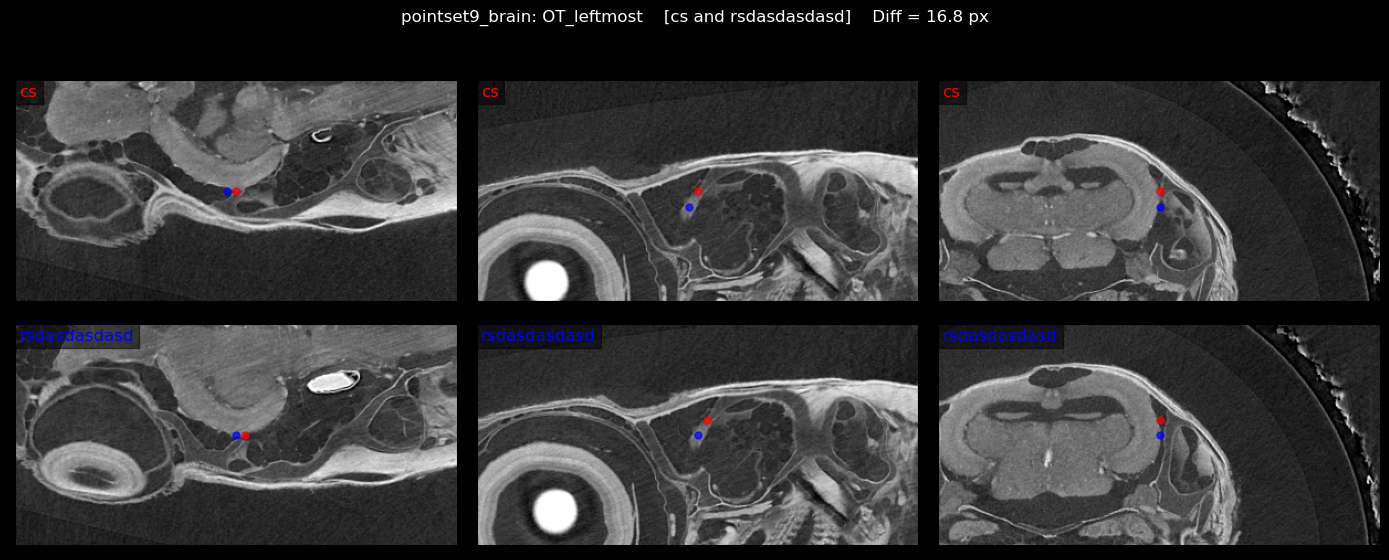

In [175]:
make_landmarks_comparison_figure_centered(im, [x,y,z], [x2,y2,z2], f'{pointset}: {landmark}', name1, name2)

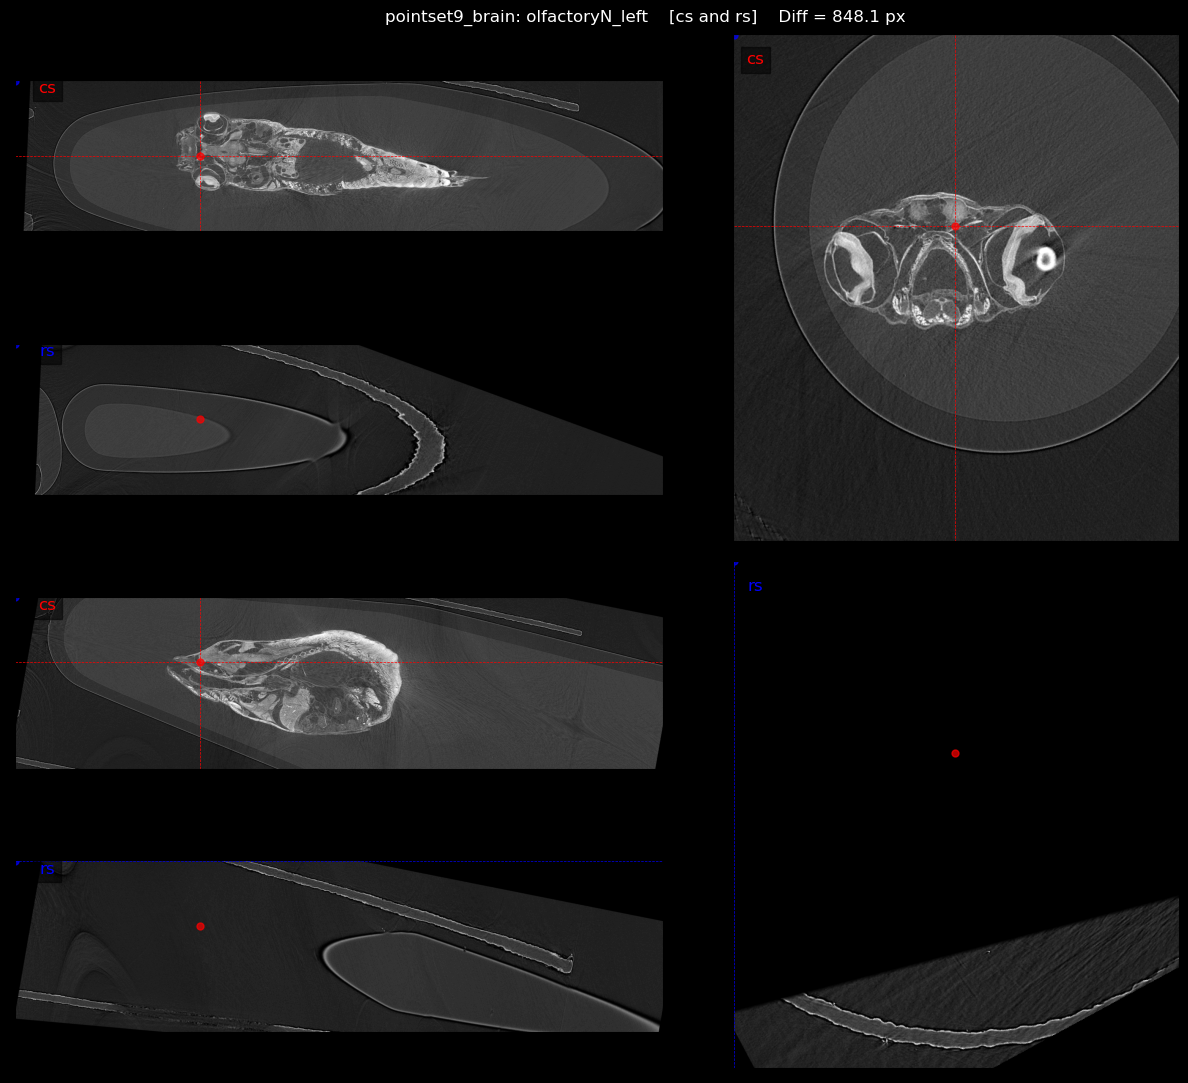

In [137]:
make_landmarks_comparison_figure(im, [x,y,z], [x2,y2,z2], f'{pointset}: {landmark}', name1, name2)